In [2]:
import numpy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tables
import aopy

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('talk')

# 

a figure that shows the convergence error as we go down. 
a figure that shows that how long it takes to converge it.

## we get a feature batch

In [6]:
# this is for creating exp_conditions that scan the difference across the files
#for comparision
#data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/more_neurons/run_3/'
data_dump_folder = \
'/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/gaussian_peaks/2022_01_31_noise_scan_range_1_to128_1/'
random_seed = 0
n_neurons = 128
# 
mean_first_peak = 50
mean_second_peak = 50
std = 10

# clda setup 
rho = 0.5
batchlen = 100

noises = np.arange(9)
noises = np.exp2(noises)
#noises = [256.0]

exp_conds = []
for noise in noises:
    exp_conds_wo = [f'wo_FS_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std}_clda_rho_{rho}_batchlen_{batchlen}' ]
    # exp_conds_add = [f'iter_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std}_clda_rho_{rho}_batchlen_{batchlen}' ]
    # exp_conds_keep = [f'same_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std}_clda_rho_{rho}_batchlen_{batchlen}' ]

    # we add to the exp list
    exp_conds.extend(exp_conds_wo)
    # exp_conds.extend(exp_conds_add)
    # exp_conds.extend(exp_conds_keep)

feature_selection_schemes = ['w/o feature selection', 'iter', 'subset throughout']

print("the folder at which data is located:")
print(data_dump_folder)
print(exp_conds)

the folder at which data is located:
/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/gaussian_peaks/2022_01_31_noise_scan_range_1_to128_1/
['wo_FS_1.0_0_noise_1.0_128_50_10_clda_rho_0.5_batchlen_100', 'wo_FS_1.0_0_noise_2.0_128_50_10_clda_rho_0.5_batchlen_100', 'wo_FS_1.0_0_noise_4.0_128_50_10_clda_rho_0.5_batchlen_100', 'wo_FS_1.0_0_noise_8.0_128_50_10_clda_rho_0.5_batchlen_100', 'wo_FS_1.0_0_noise_16.0_128_50_10_clda_rho_0.5_batchlen_100', 'wo_FS_1.0_0_noise_32.0_128_50_10_clda_rho_0.5_batchlen_100', 'wo_FS_1.0_0_noise_64.0_128_50_10_clda_rho_0.5_batchlen_100', 'wo_FS_1.0_0_noise_128.0_128_50_10_clda_rho_0.5_batchlen_100', 'wo_FS_1.0_0_noise_256.0_128_50_10_clda_rho_0.5_batchlen_100']


In [7]:
from afs_files import load_feature_selection_files
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} numbers of experiments')

we collected 9 numbers of experiments


In [8]:
# get the data batches
exp_index = 0


print("exp_index:", exp_index)
print(exp_data_all[exp_index].keys())
print(exp_data_all[exp_index]['bmi3d_clda'].dtype)

print('load the intended kin')

intended_kin = exp_data_all[exp_index]['bmi3d_clda']['intended_kin']
spike_counts_batch = exp_data_all[exp_index]['bmi3d_clda']['spike_counts_batch']

print('shapes of the data:')
print('intended kin:', intended_kin.shape)
print('spike_counts_batch:', spike_counts_batch.shape)

# only fitting to the velocities, right.
X_VEL_STATE = 3
Y_VEL_STATE = 5
CONST_STATE = 6
intended_velocities = intended_kin[:,(X_VEL_STATE, Y_VEL_STATE, CONST_STATE), :]
print('intended vel:', intended_velocities.shape)

exp_index: 0
dict_keys(['bmi3d_clda', 'bmi3d_task', 'bmi3d_state', 'bmi3d_clock', 'bmi3d_events', 'bmi3d_trials', 'task', 'state', 'clock', 'events', 'trials', 'feature_selection'])
[('kf_C', '<f8', (128, 7)), ('kf_Q', '<f8', (128, 128)), ('kf_C_xpose_Q_inv_C', '<f8', (7, 7)), ('kf_C_xpose_Q_inv', '<f8', (7, 128)), ('mFR', '<f8', (128,)), ('sdFR', '<f8', (128,)), ('rho', '<f8', (1,)), ('intended_kin', '<f8', (7, 100)), ('spike_counts_batch', '<f8', (128, 100))]
load the intended kin
shapes of the data:
intended kin: (120, 7, 100)
spike_counts_batch: (120, 128, 100)
intended vel: (120, 3, 100)


## apply feature selection to this batch of data

we can apply to feature batch

In [5]:
batch_num = 99
spike_counts_one_batch = spike_counts_batch[batch_num,:,:]
intended_vel_one_batch = intended_velocities[batch_num, :,:]


print("spike_counts_one_batch",spike_counts_one_batch.shape)
print("intended vel one batch", intended_vel_one_batch.shape)

spike_counts_one_batch (128, 100)
intended vel one batch (3, 100)


In [6]:
# we need to transpose the 
spike_counts_one_batch = spike_counts_one_batch.T
intended_vel_one_batch = intended_vel_one_batch.T

print("After transpose, each column is one feature")
print("spike_counts_one_batch",spike_counts_one_batch.shape)
print("intended vel one batch", intended_vel_one_batch.shape)

After transpose, each column is one feature
spike_counts_one_batch (100, 128)
intended vel one batch (100, 3)



# Formulating the general framework for feature selection

In [7]:
num_obs = spike_counts_one_batch.shape[0]

# data matrix: F = [f1, f2, f3, ... , fd] 
F = spike_counts_one_batch
 
#centralizer
# Hn = In - 1/n * 1n * 1n^T
Hn = np.identity(num_obs) - 1 / num_obs * np.ones((num_obs,1)) @ np.ones((num_obs,1)).T

# diagonal marix
# Dii = 1 / || Fi||
Dii = 1 / np.linalg.norm(F, axis=0)
D = np.diag(Dii)

# assemble the matrix 
B = (F @ D).T @ (F @ D)

# Hadmard product, elementwise product
A = B * B

Text(0, 0.5, 'Neuron #')

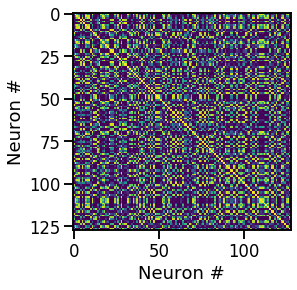

In [8]:
plt.imshow(A)
plt.xlabel('Neuron #')
plt.ylabel('Neuron #')

In [9]:
A[0,:32]

array([1.     , 0.11676, 0.04704, 0.00923, 0.06204, 0.00052, 0.00503,
       0.06113, 0.01637, 0.02249, 0.2507 , 0.13411, 0.9484 , 0.62241,
       0.00023, 0.05046, 0.22308, 0.05523, 0.00802, 0.49167, 0.15747,
       0.85203, 0.20521, 0.15183, 0.30252, 0.90276, 0.0793 , 0.00456,
       0.00926, 0.14419, 0.00543, 0.00488])

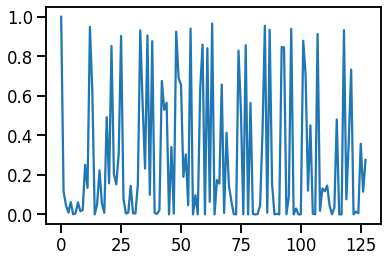

In [10]:
plt.plot(A[0,:])

## how is it diff from np.cov matrix

In [48]:
cov_F = np.cov(F.T)

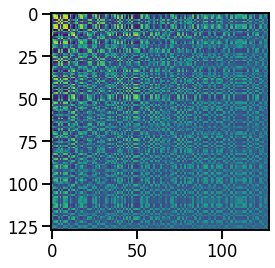

In [49]:
plt.imshow(cov_F)

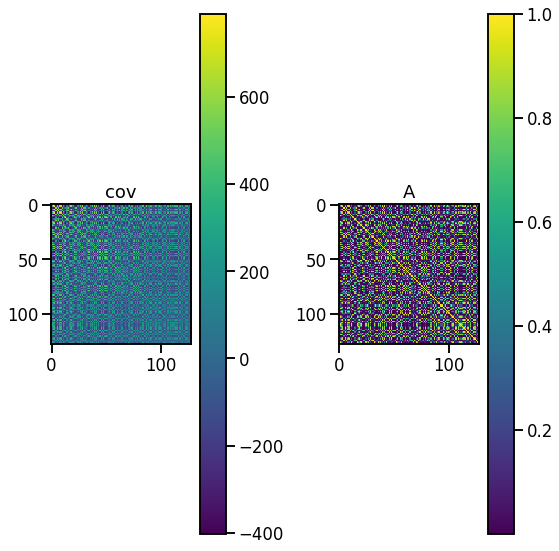

In [57]:
# compare between pairwise correlation, np.cov 
fig_compr_pair, ax_compr_pair = plt.subplots(1,2, figsize =  (8,8))

for ax, mat ,title in  zip(ax_compr_pair, [cov_F, A], ["cov", "A"] ):
    p = ax.imshow(mat)
    ax.set_title(title)
    fig_compr_pair.colorbar(p, ax = ax)
    
fig_compr_pair.tight_layout()

In [3]:
import cvxpy as cp
import numpy as np

# Problem data.
m = 30
n = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

[-0.       0.02851  0.       0.      -0.       0.14929 -0.       0.
  0.24672  0.57822 -0.       0.00101 -0.       0.22677 -0.      -0.
 -0.      -0.       0.      -0.     ]
[ 2.50939  0.       2.78355  1.79426 13.08579  0.       0.73716  3.35345
  0.       0.       8.93825  0.       7.02955  0.       4.71069  3.18874
  2.0609  10.08167  3.04812  8.53268]


## write out the first bit of equation

$min(w,b) ||W^T \theta X - b \boldsymbol{1}^T - Y\$

In [129]:
batch_num = 99
spike_counts_one_batch = spike_counts_batch[batch_num,:,:]
intended_vel_one_batch = intended_velocities[batch_num, :,:]


print("spike_counts_one_batch",spike_counts_one_batch.shape)
print("intended vel one batch", intended_vel_one_batch.shape)


# data matrix
batch_num = 99
spike_counts_one_batch = spike_counts_batch[batch_num,:,:]
intended_vel_one_batch = intended_velocities[batch_num, :,:]


print("spike_counts_one_batch",spike_counts_one_batch.shape)
print("intended vel one batch", intended_vel_one_batch.shape)

# d by n or number of features by number of time points
X = np.vstack((spike_counts_one_batch[:16, :], spike_counts_one_batch[-16:, :]))

# k by n or number of outputs by number of time points
Y = intended_vel_one_batch[:2,:] # only need the x,y velocities

print("shape of X", X.shape)
print("shape of y", Y.shape)

spike_counts_one_batch (128, 100)
intended vel one batch (3, 100)
spike_counts_one_batch (128, 100)
intended vel one batch (3, 100)
shape of X (32, 100)
shape of y (2, 100)


In [130]:

d = num_features = X.shape[0]
n = num_data_points = 100
k = num_outputs = 2

W = cp.Variable((k,d))
b = cp.Variable((k,1))

# preset
theta_0 = np.identity(d)
one_n = np.ones((n,1))

# write out the W subploblem
objective = cp.Minimize(cp.norm(W @ theta_0 @ X - Y ))
prob = cp.Problem(objective)


print("Optimal value", prob.solve())
W_norm = np.linalg.norm(W.value, axis = 0)

Optimal value 20.46779252783215


In [98]:
W.value

array([[-0.02823, -0.02787,  0.02301,  0.03716, -0.00138,  0.03925,
         0.02911,  0.04774, -0.01048, -0.04325, -0.02035,  0.01627,
        -0.04002, -0.06403,  0.03174, -0.00073, -0.0358 , -0.01175,
         0.09169, -0.03176, -0.00006,  0.03102,  0.02693,  0.03597,
        -0.00622, -0.01827,  0.06317, -0.05153,  0.01097, -0.02566,
        -0.04228, -0.02745],
       [-0.00848, -0.01499,  0.0075 ,  0.00847,  0.00932, -0.0027 ,
        -0.05741, -0.00557,  0.02238,  0.00558, -0.02324, -0.0434 ,
         0.04279,  0.00722, -0.01455, -0.03449,  0.03013, -0.05528,
        -0.11164, -0.02478,  0.01222, -0.04113,  0.00654,  0.14033,
        -0.01293, -0.02417,  0.03523,  0.02498, -0.03501,  0.04509,
         0.2349 , -0.01381],
       [-0.00141, -0.00818,  0.00943,  0.0011 , -0.01448,  0.00928,
         0.00695, -0.00189, -0.00284,  0.00189,  0.00393,  0.00787,
         0.00469,  0.00248,  0.00508,  0.01267,  0.00383, -0.00256,
        -0.02115,  0.00186, -0.01817,  0.02025, -0.00068, 

Text(0, 0.5, 'Norm of each feature')

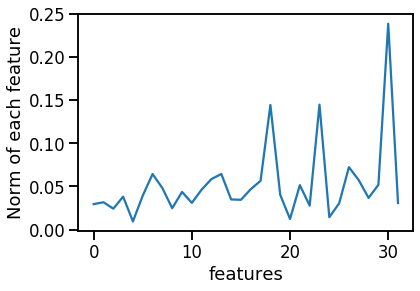

In [133]:
plt.plot(W_norm)
plt.xlabel("features")
plt.ylabel("Norm of each feature")

<ipython-input-134-d625c9f5f57f>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W_lsq = np.linalg.lstsq(X.T, Y.T, rcond='warn')[0]


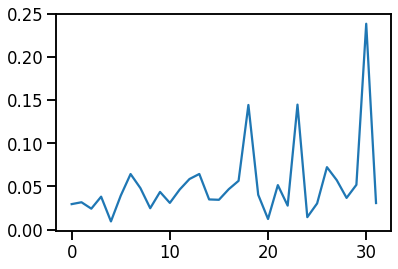

In [134]:
W_lsq = np.linalg.lstsq(X.T, Y.T, rcond='warn')[0]

W_lsq_norm = np.linalg.norm(W_lsq, axis = 1)

plt.plot(W_lsq_norm)

Optimal value 913.9620564775217


Text(0, 0.5, 'Norm of each feature')

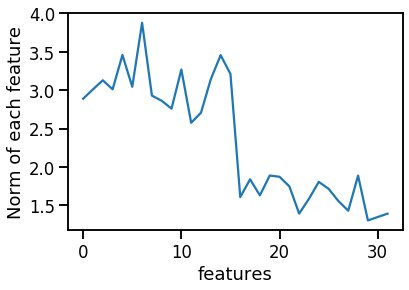

In [135]:
# the below code does not make sense.
# let's try to fit the obs mat as in KF

C = cp.Variable((d,k))


# write out the W subploblem
objective = cp.Minimize(cp.norm(X - C @ Y ))
prob = cp.Problem(objective)


print("Optimal value", prob.solve())

C_norm = np.linalg.norm(C.value, axis = 1)


plt.plot(C_norm)
plt.xlabel("features")
plt.ylabel("Norm of each feature")

## we add the second objective into this equation


In [136]:


# data matrix: F = [f1, f2, f3, ... , fd] 
F = X.T
 
#centralizer
# Hn = In - 1/n * 1n * 1n^T
Hn = np.identity(num_obs) - 1 / num_obs * np.ones((num_obs,1)) @ np.ones((num_obs,1)).T

# diagonal marix
# Dii = 1 / || Fi||
Dii = 1 / np.linalg.norm(F, axis=0)
D = np.diag(Dii)

# assemble the matrix 
B = (F @ D).T @ (F @ D)

# Hadmard product, elementwise product
A = B * B

In [143]:
b.value

In [144]:
# lambda, that controls the degree of redundency
lam = 1

# theta with dim, number of features
theta = cp.Variable(d)
ones_d = np.ones(d)
print(theta.shape)

W_fixed = W.value
b_fixed = b.value

# write out the W subploblem
objective_redundency  = cp.Minimize(cp.norm(W_fixed @ cp.diag(theta) @ X  - Y ) \
                                    + lam * cp.quad_form(theta, A)) 
#objective_redundency = cp.Minimize() 
constraints = [theta >=0, theta <= 1]
prob_redundency = cp.Problem(objective_redundency, constraints)

print("Redundency Optimal value", prob_redundency.solve())

(32,)
Redundency Optimal value 48.42379834285555


Text(0, 0.5, 'feature value score')

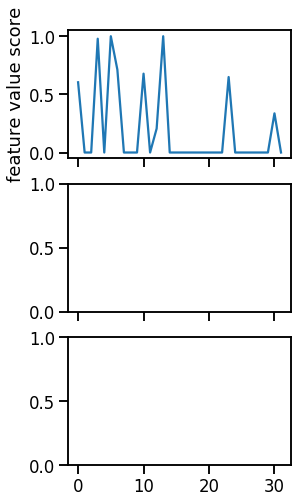

In [145]:
fig_rel, ax_rel = plt.subplots(3,1,figsize = (4, 8),sharex = True)

ax_rel[0].plot(theta.value)
ax_rel[0].set_ylabel("feature value score")

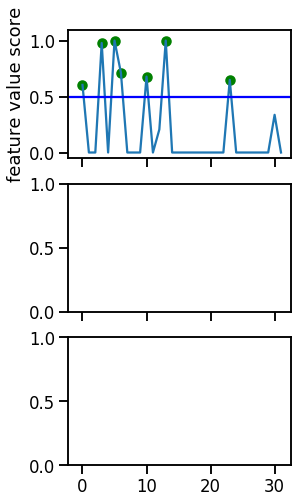

In [146]:
threshold = 0.5
features_cross_threshold = np.argwhere(theta.value >= threshold)

ax_rel[0].scatter(features_cross_threshold, theta.value[features_cross_threshold], color = "g")
ax_rel[0].axhline(threshold, color = 'b')
fig_rel

In [149]:
ax_rel[1].plot(W_norm,color = 'b')
ax_rel[1].scatter(features_cross_threshold, 
            W_norm[features_cross_threshold], color = "g")
ax_rel[1].set_ylabel("norm Wi")

Text(25.200000000000003, 0.5, 'norm Wi')

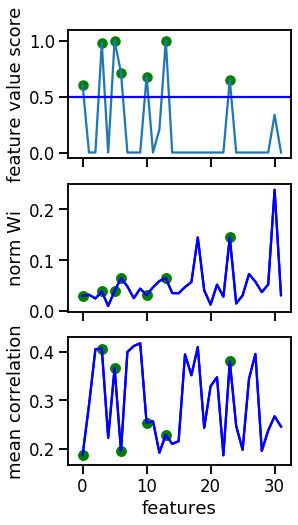

In [150]:
# getting rid of the diagonal,self correlation and average the correlation with other terms.
A_mea_corr = np.sum(A - np.identity(d), axis = 1) / (d-1)

ax_rel[2].plot(A_mea_corr,color = 'b')
ax_rel[2].scatter(features_cross_threshold, 
            A_mea_corr[features_cross_threshold], color = "g")

ax_rel[2].set_xlabel("features")
ax_rel[2].set_ylabel("mean correlation")

fig_rel

## let's think about an alternative problem formulation

# more iterations

In [173]:
Y.shape

(2, 100)

[Inequality(Constant(CONSTANT, ZERO, ())), Inequality(Variable((32,)))]

In [277]:

i = 0
lam = 1
MAX_ITERATIONS = 6
#objective_redundency = cp.Minimize() 

W = cp.Variable((k,d))
theta = cp.Variable((d,1))
constraints = [theta >=0.0001, theta <= 1]

W_fixed = cp.Parameter((k,d))
theta_fixed = cp.Parameter((d,1))


theta_fixed.value = np.ones((d,1))
theta_ff = 0.0001

W_record, theta_record = list(), list()

while i < MAX_ITERATIONS:
    

    relevance_objective = cp.Minimize(cp.norm(W @ cp.diag(theta_fixed) @ X - Y ))
    relevance_prob = cp.Problem(relevance_objective)
    relevance_optimal = relevance_prob.solve()
    

    # fix  W.value
    W_fixed.value = np.copy(W.value)

    # write out the W subploblem
    objective_redundency  = cp.Minimize(cp.norm(W_fixed @ cp.diag(theta) @ X  - Y ) \
                                        + lam * cp.quad_form(theta, A)) 

    prob_redundency = cp.Problem(objective_redundency, constraints)
    redundency_optimal = prob_redundency.solve(verbose = False)

    # fix 
    theta_fixed.value = np.copy(theta.value)
    
    #print(theta_fixed.value)

    # save overall data
    W_record.append(np.copy(W.value))
    theta_record.append(np.copy(theta.value))
    
    print("finished", i, relevance_optimal, redundency_optimal)
    i += 1



finished 0 20.46779252783215 48.43103930341126
finished 1 20.467792527832145 21.488848521134745
finished 2 20.467792527832152 20.559278216989526
finished 3 20.46779252783214 20.517827641049635
finished 4 20.46779252783215 20.506548155219058
finished 5 20.467792527832152 20.501146122084094


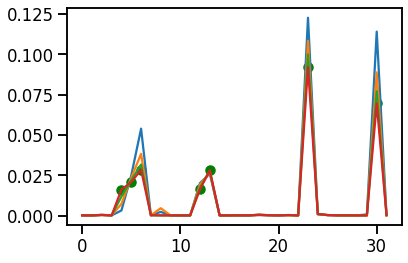

In [278]:
for th in theta_record[2:]:
    plt.plot(th)
features_cross_threshold = np.argwhere(np.squeeze(theta_record[-1]) >= 0.015)
plt.scatter(features_cross_threshold, 
            th[features_cross_threshold], color = "g")

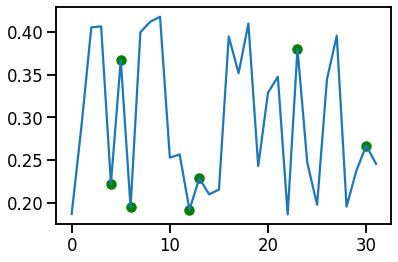

In [279]:

plt.plot(A_mea_corr)
plt.scatter(features_cross_threshold, 
            A_mea_corr[features_cross_threshold], color = "g")

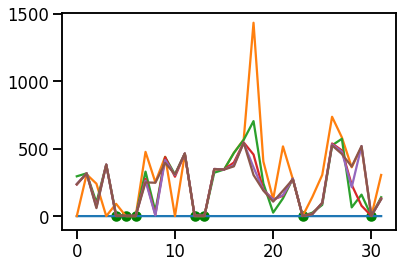

In [280]:
for rel in W_record:
    plt.plot(np.linalg.norm(rel, axis = 0))
    
plt.scatter(features_cross_threshold, 
            np.linalg.norm(rel, axis = 0)[features_cross_threshold], color = "g")

# Simple formulation of the objective fxn

In [4]:
import cvxpy as cp
import numpy as np

In [9]:
# we just need to grab a c matrix and q matrix
# get the data batches
exp_index = 0


print("exp_index:", exp_index)
print(exp_data_all[exp_index].keys())
print(exp_data_all[exp_index]['bmi3d_clda'].dtype)

print('load the intended kin')

intended_kin = exp_data_all[exp_index]['bmi3d_clda']['intended_kin']
spike_counts_batch = exp_data_all[exp_index]['bmi3d_clda']['spike_counts_batch']

print('shapes of the data:')
print('intended kin:', intended_kin.shape)
print('spike_counts_batch:', spike_counts_batch.shape)

# only fitting to the velocities, right.
X_VEL_STATE = 3
Y_VEL_STATE = 5
CONST_STATE = 6
intended_velocities = intended_kin[:,(X_VEL_STATE, Y_VEL_STATE, CONST_STATE), :]
print('intended vel:', intended_velocities.shape)

exp_index: 0
dict_keys(['bmi3d_clda', 'bmi3d_task', 'bmi3d_state', 'bmi3d_clock', 'bmi3d_events', 'bmi3d_trials', 'task', 'state', 'clock', 'events', 'trials', 'feature_selection'])
[('kf_C', '<f8', (128, 7)), ('kf_Q', '<f8', (128, 128)), ('kf_C_xpose_Q_inv_C', '<f8', (7, 7)), ('kf_C_xpose_Q_inv', '<f8', (7, 128)), ('mFR', '<f8', (128,)), ('sdFR', '<f8', (128,)), ('rho', '<f8', (1,)), ('intended_kin', '<f8', (7, 100)), ('spike_counts_batch', '<f8', (128, 100))]
load the intended kin
shapes of the data:
intended kin: (120, 7, 100)
spike_counts_batch: (120, 128, 100)
intended vel: (120, 3, 100)


In [14]:
# probably the last one

C_record = exp_data_all[exp_index]['bmi3d_clda']['kf_C']
print(C_record.shape)


(120, 128, 7)


In [5]:
theta = cp.Variable((d,1))
constraints = [theta >=0.0001, theta <= 1]

NameError: name 'd' is not defined